## Setup

First, let's grab the necessary Python packages:

In [158]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
import datetime
from datetime import date
import math

%matplotlib inline
sns.set_context('paper')
style.use('ggplot')

## Get the Data

To look at NYC crimes, we will be using the NYPD arrest data from [NYC OpenData](https://data.cityofnewyork.us/Public-Safety/NYPD-Arrest-Data-Year-to-Date-/uip8-fykc). The dataset is a breakdown of every arrest effected in NYC by the NYPD in 2022 (with the last update on July 15, 2022).  

Let's import the data and take a look.

In [159]:
arrests = pd.read_csv("NYPD_Arrest_Data__Year_to_Date_.csv")
arrests[:5]

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,238552639,01/03/2022,205.0,"TRESPASS 2, CRIMINAL",352.0,CRIMINAL TRESPASS,PL 1401501,M,K,75,0,18-24,M,BLACK,1015028,185895,40.676863,-73.889037,POINT (-73.889037 40.676863)
1,238682242,01/05/2022,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 160050H,F,K,75,0,25-44,M,BLACK,1017119,183909,40.671404,-73.881509,POINT (-73.881509 40.671404)
2,238723993,01/06/2022,153.0,RAPE 3,104.0,RAPE,PL 1302503,F,K,77,0,25-44,M,WHITE,1003509,185018,40.674496,-73.930571,POINT (-73.9305713255961 40.6744956865259)
3,238821533,01/08/2022,NaN,(null),NaN,(null),CPL5700600,9,Q,113,3,45-64,M,WHITE HISPANIC,1046367,186986,40.679701,-73.776047,POINT (-73.77604735 40.67970059)
4,239029586,01/12/2022,NaN,(null),NaN,(null),CPL5700600,9,Q,113,3,25-44,M,WHITE HISPANIC,1046367,186986,40.679701,-73.776047,POINT (-73.77604735 40.67970059)


The column names are coded so we need to look back at the documentation. Here's what each column represents:
1. `ARREST_KEY`: randomly generated persistent ID for each arrest
2. `ARREST_DATE`: exact date of arrest for the reported event
3. `PD_CD`: three digit internal classification code (more granular thatn `KY_CD`)
4. `PD_DESC`: description of internal classification, corresponding to PD code (more granular than `OFNS_DESC`)
5. `KY_CD`: three digit internal classification code (more general than `PD_CD`)
6. `OFNS_DESC`: description of internal classification, corresopnding to KY code (more general than `PD_DESC`)
7. `LAW_CODE`: law code charges corresponding to NYS Penal Law, VTL, and other various local laws
8. `LAW_CAT_CD`: level of offense
9. `ARREST_BORO`: borough of arrest
10. `ARREST_PRECINCT`: precinct of arrest
11. `JURISDICTION_CODE`: jurisdiction responsible for arrest
12. `AGE_GROUP`: perpetrator's age within a category
13. `PERP_SEX`: perpetrator's sex description
14. `PERP_RACE`: perpetrator's race description
15. `X_COORD_CD`: midblock X-coordinate for NY State Plane Coordinate System
16. `Y_COORD_CD`: midblock Y-coordinate for NY State Plane Coordinate System
17. `Latitude`: latitude coordinate for Global Coordinate System
18. `Longitude`: longtitude coordinate for Global Coordinate System
19. `New Georeferenced Column`

Let's organize the data a little bit.

First, we should decode the level of offense in `LAW_CAT_CD`. The unique values in the dataset for this column are:

In [160]:
arrests.LAW_CAT_CD.unique()

array(['M', 'F', '9', nan, 'V', 'I'], dtype=object)

Oops, there are `nan` values. Let's drop those in the dataset.

In [161]:
arrests = arrests.dropna(subset=['LAW_CAT_CD'])
arrests.LAW_CAT_CD.unique()

array(['M', 'F', '9', 'V', 'I'], dtype=object)

The four codes that are officially documented are `F`, `M`, `V`, and `I`. The value `9` seems to be either an entry error or an inconsistency in the dataset, undefined by the documentation. We should clean this up:

In [162]:
arrests = arrests[arrests.LAW_CAT_CD != '9']
arrests.LAW_CAT_CD.unique()

array(['M', 'F', 'V', 'I'], dtype=object)

Nice, we can now write a decoding function:

In [163]:
def cd_to_off(cd):
    cd_dict = {'F': 'Felony',
               'M': 'Misdemeanor', 
               'V': 'Violation', 
               'I': 'Other'}
    return cd_dict[cd]

arrests['LAW_CAT_CD'] = arrests['LAW_CAT_CD'].apply(cd_to_off)

Next, we should convert the borough codes in `ARREST_BORO` into names:

In [164]:
arrests.ARREST_BORO.unique()

array(['K', 'S', 'Q', 'B', 'M'], dtype=object)

In [165]:
def cd_to_boro(cd):
    cd_dict = {'B': 'Bronx', 
               'S': 'Staten Island', 
               'K': 'Brookyln', 
               'M': 'Manhattan', 
               'Q': 'Queens'}
    return cd_dict[cd]

arrests['ARREST_BORO'] = arrests['ARREST_BORO'].apply(cd_to_boro)

For `JURISDICTION_CODE`, `0` (Patrol), `1` (Transit), `2` (Housing) represent NYPD whilst codes `3` and more represent non-NYPD jurisdictions.

In [166]:
arrests.JURISDICTION_CODE.unique() 

array([ 0,  2,  1,  3, 97, 15, 73, 71, 11, 72, 87,  7, 14,  4,  6, 88, 74,
       69, 85, 13, 16])

Let's make a dummy variable for whether the jurisdiction is NYPD or not:

In [167]:
arrests['JURISDICTION_NYPD'] = np.where(arrests.JURISDICTION_CODE.isnull(), np.nan, arrests.JURISDICTION_CODE < 3)

Now, let's work with the `ARREST_DATE` variable and make it a little more informative by dividing up into parts. We strip the weekday, month, and day. We don't care about year since all of the crimes are from the 2022 dataset.

In [168]:
def date_to_weekday(date):
    weekday_dict = {0: 'Monday',
                    1: 'Tuesday',
                    2: 'Wednesday',
                    3: 'Thursday',
                    4: 'Friday',
                    5: 'Saturday', 
                    6: 'Sunday'}
    date_time = datetime.datetime.strptime(date, '%m/%d/%Y')
    return weekday_dict[date_time.weekday()]

arrests['weekday'] = arrests['ARREST_DATE'].apply(date_to_weekday)
date = arrests['ARREST_DATE'].str.split("/", n = 3, expand = True)
arrests['day'] = date[1].astype('int32')
arrests['month'] = date[0].astype('int32')

arrests[:5]

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,...,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column,JURISDICTION_NYPD,weekday,day,month
0,238552639,01/03/2022,205.0,"TRESPASS 2, CRIMINAL",352.0,CRIMINAL TRESPASS,PL 1401501,Misdemeanor,Brookyln,75,...,BLACK,1015028,185895,40.676863,-73.889037,POINT (-73.889037 40.676863),1.0,Monday,3,1
1,238682242,01/05/2022,397.0,"ROBBERY,OPEN AREA UNCLASSIFIED",105.0,ROBBERY,PL 160050H,Felony,Brookyln,75,...,BLACK,1017119,183909,40.671404,-73.881509,POINT (-73.881509 40.671404),1.0,Wednesday,5,1
2,238723993,01/06/2022,153.0,RAPE 3,104.0,RAPE,PL 1302503,Felony,Brookyln,77,...,WHITE,1003509,185018,40.674496,-73.930571,POINT (-73.9305713255961 40.6744956865259),1.0,Thursday,6,1
5,239104920,01/13/2022,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,Misdemeanor,Brookyln,77,...,BLACK,1003508,185056,40.674593,-73.930572,POINT (-73.930572 40.674593),1.0,Thursday,13,1
7,239623520,01/24/2022,101.0,ASSAULT 3,344.0,ASSAULT 3 & RELATED OFFENSES,PL 1200001,Misdemeanor,Brookyln,60,...,WHITE,990796,149587,40.577258,-73.976436,POINT (-73.976436 40.577258),1.0,Monday,24,1


To further clean up the data, let's remove columns we won't be using. I'll also make the column names a little more intuitive. And most importantly, because I hate inconsistent capitalization, let me go ahead and clean that all up. It may seem a little excessive but it makes me happy, alright?

In [169]:
arrests = arrests.drop(['ARREST_KEY', 'PD_CD', 'PD_DESC', 'KY_CD', 'OFNS_DESC', 'LAW_CODE', 'X_COORD_CD', 'Y_COORD_CD'], axis = 1)
arrests[:5]

,ARREST_DATE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,Latitude,Longitude,New Georeferenced Column,JURISDICTION_NYPD,weekday,day,month
0,01/03/2022,Misdemeanor,Brookyln,75,0,18-24,M,BLACK,40.676863,-73.889037,POINT (-73.889037 40.676863),1.0,Monday,3,1
1,01/05/2022,Felony,Brookyln,75,0,25-44,M,BLACK,40.671404,-73.881509,POINT (-73.881509 40.671404),1.0,Wednesday,5,1
2,01/06/2022,Felony,Brookyln,77,0,25-44,M,WHITE,40.674496,-73.930571,POINT (-73.9305713255961 40.6744956865259),1.0,Thursday,6,1
5,01/13/2022,Misdemeanor,Brookyln,77,0,45-64,M,BLACK,40.674593,-73.930572,POINT (-73.930572 40.674593),1.0,Thursday,13,1
7,01/24/2022,Misdemeanor,Brookyln,60,0,45-64,M,WHITE,40.577258,-73.976436,POINT (-73.976436 40.577258),1.0,Monday,24,1


In [175]:
arrests.columns = ['date',
                   'offense',
                   'borough',
                   'precinct',
                   'jurisdiction',
                   'age',
                   'sex',
                   'race',
                   'latitude',
                   'longitude',
                   'georeferenced',
                   'nypd',
                   'weekday',
                   'day', 
                   'month']
arrests[:5]

,date,offense,borough,precinct,jurisdiction,age,sex,race,latitude,longitude,georeferenced,nypd,weekday,day,month
0,01/03/2022,Misdemeanor,Brookyln,75,0,18-24,M,BLACK,40.676863,-73.889037,POINT (-73.889037 40.676863),1.0,Monday,3,1
1,01/05/2022,Felony,Brookyln,75,0,25-44,M,BLACK,40.671404,-73.881509,POINT (-73.881509 40.671404),1.0,Wednesday,5,1
2,01/06/2022,Felony,Brookyln,77,0,25-44,M,WHITE,40.674496,-73.930571,POINT (-73.9305713255961 40.6744956865259),1.0,Thursday,6,1
5,01/13/2022,Misdemeanor,Brookyln,77,0,45-64,M,BLACK,40.674593,-73.930572,POINT (-73.930572 40.674593),1.0,Thursday,13,1
7,01/24/2022,Misdemeanor,Brookyln,60,0,45-64,M,WHITE,40.577258,-73.976436,POINT (-73.976436 40.577258),1.0,Monday,24,1


So much better!

## Basic Exploration

Now that we've cleaned up the data, let's do some primary exploration. The plots below are simple count plots for the number of arrests by each of the features.

[Text(0.5, 1.0, 'Number of Arrests by NYPD or non-NYPD Jurisdiction')]

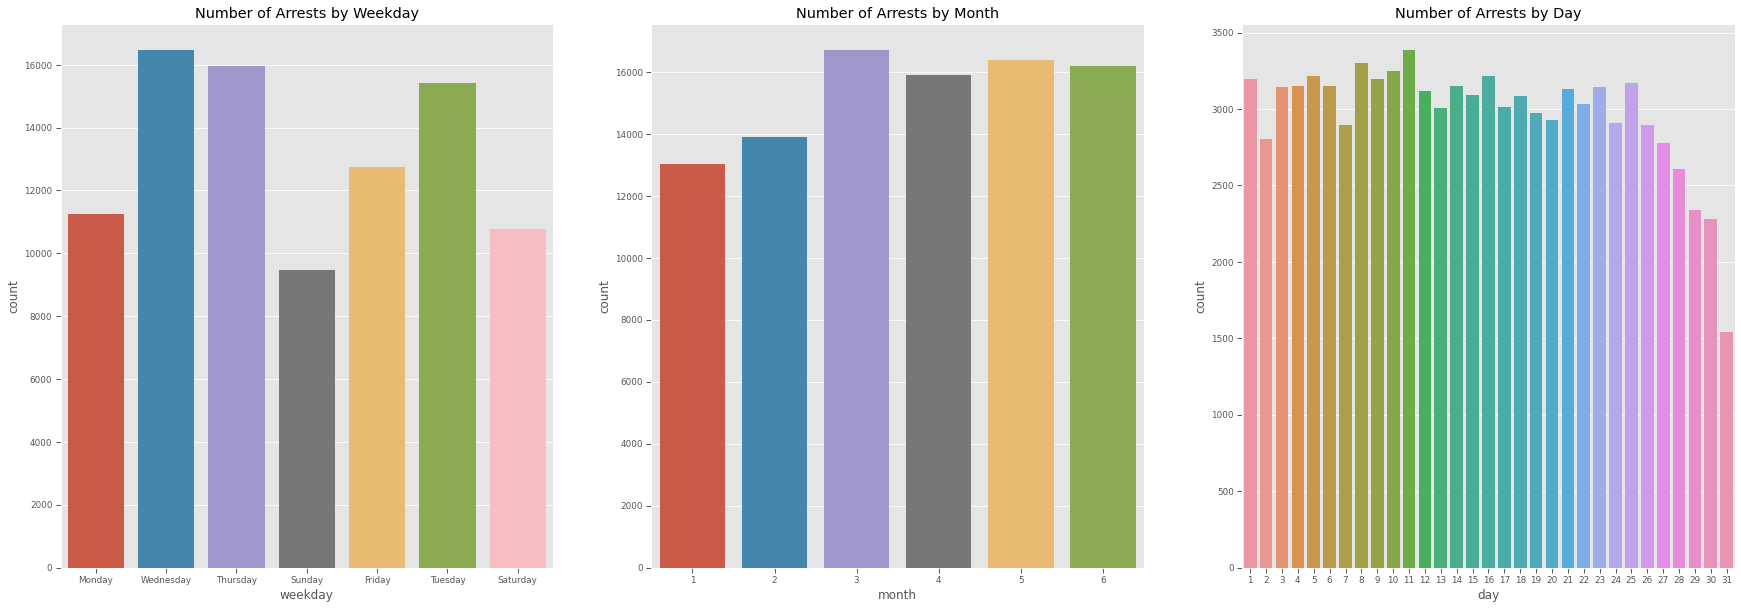

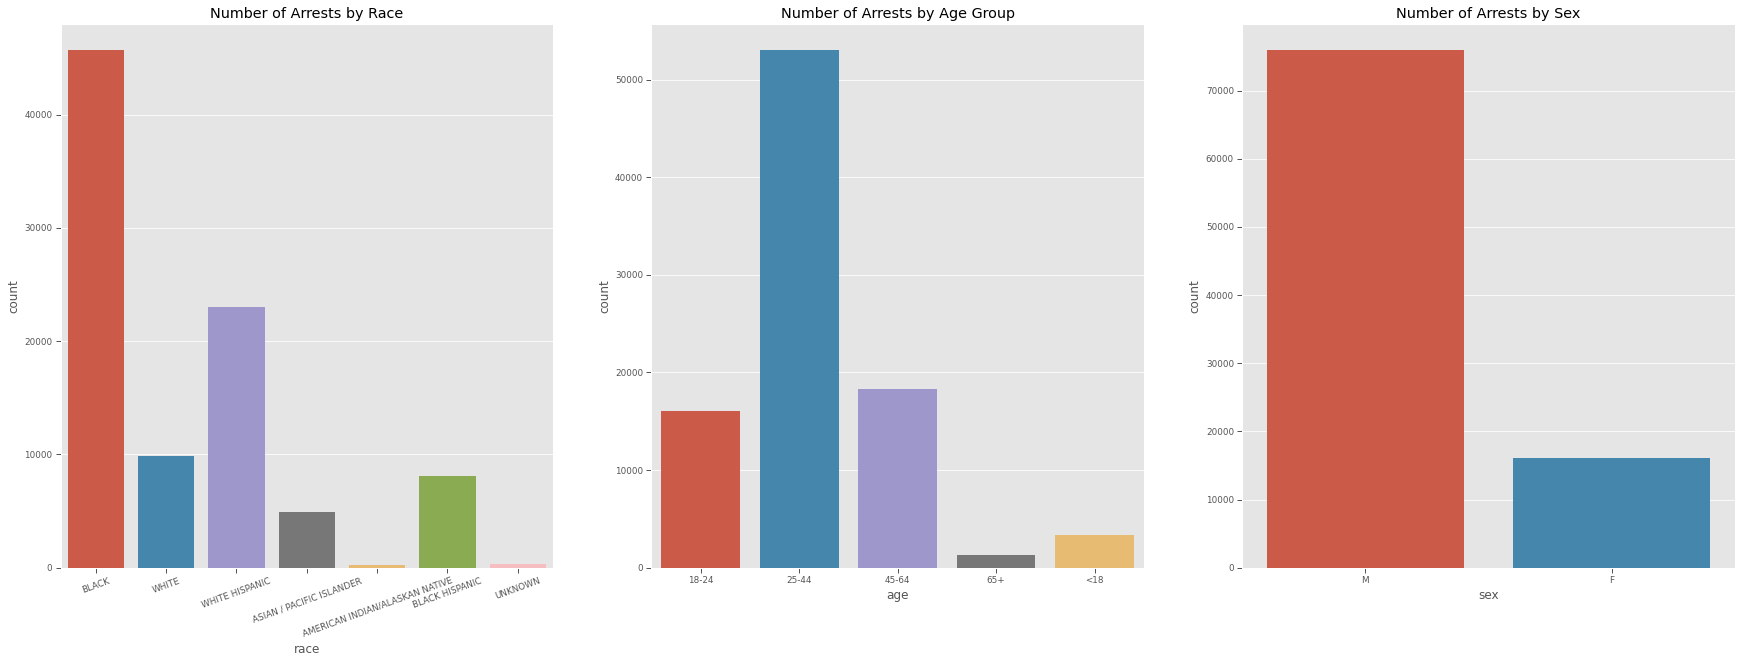

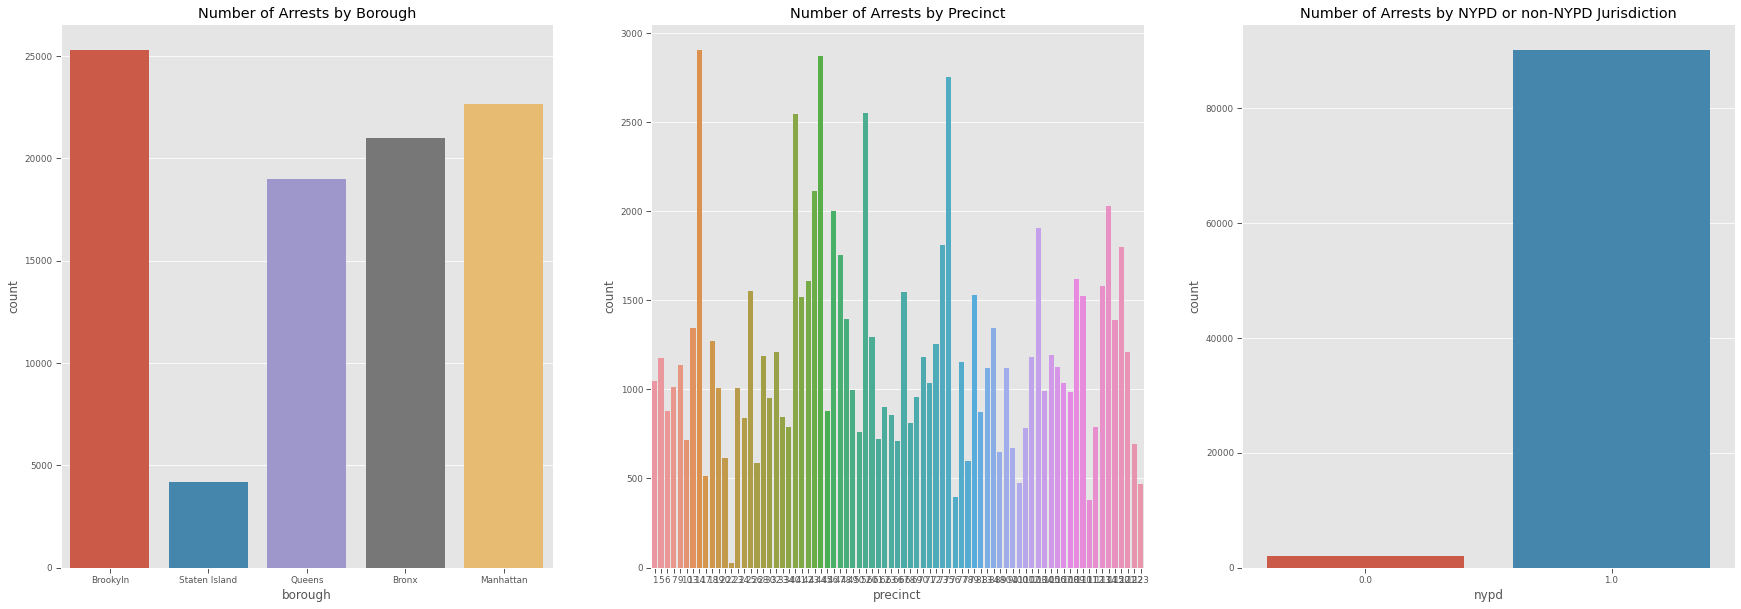

In [119]:
f, axs = plt.subplots(figsize=(30, 10), ncols=3)
sns.countplot(x = "weekday", data = arrests, ax = axs[0]).set(title = "Number of Arrests by Weekday")
sns.countplot(x = "month", data = arrests, ax = axs[1]).set(title = "Number of Arrests by Month")
sns.countplot(x = "day", data = arrests, ax = axs[2]).set(title = "Number of Arrests by Day")

f, axs = plt.subplots(figsize=(30, 10), ncols=3)
ax = sns.countplot(x = "race", data = arrests, ax = axs[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 20)
ax.set(title = "Number of Arrests by Race")
sns.countplot(x = "age", data = arrests, ax = axs[1]).set(title = "Number of Arrests by Age Group")
sns.countplot(x = "sex", data = arrests, ax = axs[2]).set(title = "Number of Arrests by Sex")

f, axs = plt.subplots(figsize=(30, 10), ncols=3)
sns.countplot(x = "borough", data = arrests, ax = axs[0]).set(title = "Number of Arrests by Borough")
sns.countplot(x = "precinct", data = arrests, ax = axs[1]).set(title = "Number of Arrests by Precinct")
sns.countplot(x = "nypd", data = arrests, ax = axs[2]).set(title = "Number of Arrests by NYPD or non-NYPD Jurisdiction")

It's been a while since I last made plots via Python (instead of R) so I thought I'd make a few plots.

## Geospatial Visualization

The main portion of today's project is learning to use geospatial visualization to look at the data. First, we need to import the packages necessary for an interactive map visualization. This is my first time using `Folium`!

Essentially, `Folium` is a Python wrapper for `Leaflet.js` and with just a few instructions, the JS in the backend does most of the work and we get really cool maps. I referenced [this documentation](https://python-visualization.github.io/folium/modules.html) for `Folium`.

In [ ]:
import folium
import folium.plugins as plugins
from random import sample 
import geopandas as gpd

Fortunately, many have used the NYC crime data for geospatial visualization projects before myself so I had an abundance of resources to look to in better understanding the documentation (not to mention other case studies of using `Folium`).

### Static Heatmap

Let's display the crimes on a static heatmap first. I referenced [this tutorial by Analytics Vidhya](https://www.analyticsvidhya.com/blog/2020/06/guide-geospatial-analysis-folium-python/).

In [179]:
positions = list(zip(arrests['latitude'], arrests['longitude']))
fol = folium.Map(location = [40.74, -73.98], zoom_start = 10, tiles = "CartoDB positron")
pos_samp = sample(positions, 25000)
HeatMap(pos_samp, radius = 8).add_to(fol) 
fol

### Time-Lapse Heatmap

Now, we construct a heatmap that displays the crimes over time from January 1 to June 30. I referenced [this tutorial by Eduardo Virtuoso](https://medium.com/nerd-for-tech/time-lapse-heat-maps-with-folium-1847f53ec956).

In [177]:
weights = []
arrests['size'] = 1

for x in arrests['date'].sort_values().unique():
    weights.append(arrests.loc[arrests['date'] == x,
                               ['latitude', 'longitude', 'size']].groupby(['latitude', 'longitude'])
                                .sum().reset_index().values.tolist())

In [178]:
fol_time = folium.Map(location = [40.74, -73.98], control_scale = True,
                      zoom_start = 10, tiles = "CartoDB positron")
HeatMapWithTime(weights, radius = 10, auto_play = True, 
                min_opacity = 0.5, max_opacity = 1,
                use_local_extrema = True).add_to(fol_time)
fol_time